# Post Regrid Data Handling

Goal is to have a streamlined way to access the files a user needs given a set of parameters. Envisioning something where a user could enter:
* Sectors of interest (or "all")
* Timerange of interest
* Spatial bounding box
* Gas species of interest    

And be returned either an xarray object with dask parallelization, or create a new netCDF/set of netCDF files to be loaded by the user later. 

There is obviously lots of work to be done, but this is a good start if you want to start playing with data. 


In [1]:
import xarray as xr
import pandas as pd
import os
import pyproj
import numpy as np
import xesmf as xe
import calendar
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

import noaa_csl_funcs as ncf

### Working on this class. More to do, but the cells below should work
TODO is merging point and area data effectively. More in the readme

In [2]:
#Define classes
class Regridded_CSL_Handler:
    '''A class to handle NOAA CSL inventory data that has been regridded and organized by regrid_data.py'''

    def __init__(self,regridded_path,bau_or_covid='COVID'):
        '''Everything revolves around the "regridded_path", which determines sectors via the filenames contained within'''

        self.regridded_path = regridded_path
        self.sectors = self.get_sectors()
        self.bau_or_covid = bau_or_covid

    def get_sectors(self):
        '''Lists the sectors in the regridded data storage path'''

        sector_list = ncf.listdir_visible(self.regridded_path)
        sectors = {'area':[],'point':[]}
        for sector in sector_list:
            if 'area' in sector:
                sectors['area'].append(sector)
            elif 'point' in sector:
                sectors['point'].append(sector)
            else:
                raise ValueError(f"Unexpected sector type {sector}, not point or area.")
        return sectors

    def get_sector_subset_list(self,sector_subset):
        '''Gets a subset of the sectors which could be one, all, or some
        
        Args:
        sector_subset (str,list): "all" will return all sectors,  'point' will return point sectors, 'area' will return area sectors, a list will just return that list
        
        Returns:
        sector_subset_list (list) : list of sectors in the subset. 
        '''

        if sector_subset == 'all':
            sector_subset_list = []
            for k,v in self.sectors.items():
                sector_subset_list.extend(v)
            return sector_subset_list
        elif type(sector_subset)==str:
            return self.sectors[sector_subset]
        else:
            return sector_subset

    def get_days_in_range(self,dt1,dt2,day_types,sector_subset = 'all',add_path=True):
        '''Gets all filepaths to the day_type level that are within a datetime range
        
        Args:
        dt1 (datetime.date) : a date, datetime, etc to start the range (will only use year and month)
        dt2 (datetime.date) : a date, datetime, etc to end the range (will only use year and month)
        sectors (list) : list of sectors to include in the list
        day_types (list) : list of day types to include in the list
        add_path (bool, optional) : if true (default) it will add the regridded path to each element

        Returns:
        days_in_range (list) : list of paths to files that are within the date range and sector, day_types, etc. 
        '''

        dates_list = pd.date_range(dt1,dt2,freq = 'MS') #get a list of all the months between the dts
        sector_subset_list = self.get_sector_subset_list(sector_subset)
        days_in_range = []
        for date in dates_list:
            for sector in sector_subset_list:
                for day_type in day_types:
                    day_path = f'{sector}/{ncf.yr_to_yrstr(sector,date.year,self.bau_or_covid)}/{ncf.month_int_to_str(date.month)}/{day_type}'
                    if add_path:
                        days_in_range.append(os.path.join(self.regridded_path,day_path))
                    else:
                        days_in_range.append(day_path)
        return days_in_range
    
    def get_files_in_days(self,days_paths):
        '''Gets the files that exist in the paths
        
        Args:
        days_path (list) : list of paths to the days folders
        
        Returns:
        files (list) : list of files in those days' paths'''

        files = []
        for day_path in days_paths:
            files.extend(ncf.listdir_visible(day_path,add_path=True))
        return files


#Define Functions
def preprocess_regridded(ds,extent=None):
    '''Preprocesses the regridded dataset when loaded to add attributes needed for concatenation
    
    Args:
    ds (xr.DataSet) : the dataset to process
    extent (dict) : a dictionary with 4 elements defining the bounding box -- must include 'lat_min', 'lat_max', 'lon_min', 'lon_max'. These are inclusive. Defaults to "None" which will return the whole ds
    
    Returns 
    ds (xr.DataSet) : the dataset, with added coordinates taken from the attributes, sliced to the input extent
    '''

    grid_type = ds.attrs['grid_type']
    if grid_type == 'area':
        ds = ds.assign_coords(sector = 'area_'+ ds.attrs['sector_id']) #add back the area, was cut off in attributes for some reason
    elif grid_type == 'point':
        ds = ds.assign_coords(sector = 'point_'+ ds.attrs['sector_id']) #add back the point, was cut off in attributes for some reason

    ds = ds.assign_coords(day_type = ds.attrs['day_type']) #assign the day_type coordinate
    ds = ds.assign_coords(yr_mo=f'{ds.attrs['year']}-{ds.attrs['month']}') #assign the year/month coordinate
    ds = ds.expand_dims(dim=['sector','day_type','yr_mo']) #make the coordinates into dimensions
    if extent is not None:
        ds = slice_extent(ds,extent) #slice to the bounding box extent

    try:
        del ds.attrs['nc_fpath'] #we don't need this attribute -- it points to an old nc path. 
    except:
        pass

    return ds

def slice_extent(ds,extent):
    '''Slice a dataset to a bounding box defined by the extent argument
    
    Args:
    ds (xr.DataSet) : the dataset to process
    extent (dict) : a dictionary with 4 elements defining the bounding box -- must include 'lat_min', 'lat_max', 'lon_min', 'lon_max' -- inclusive.

    Returns:
    ds (xr.DataSet) : the dataset clipped to within the extent range
    '''

    grid_type = ds.attrs['grid_type']
    if grid_type == 'area': #if it's an area grid
        ds = ds.sel(lat=slice(extent['lat_min'],
                              extent['lat_max']),
                    lon=slice(extent['lon_min'],
                              extent['lon_max'])) #we can slice on the lat lon coordinates
    elif grid_type == 'point': #if it's a point grid
        ds = ds.where(((ds.lat>=extent['lat_min'])&
                       (ds.lat<=extent['lat_max'])&
                       (ds.lon>=extent['lon_min'])&
                       (ds.lon<=extent['lon_max'])).compute(),drop=True) #we have to select the individual points using .where, and compute them. The drop term gets rid of NA's not in the extent
    else: 
        raise TypeError('Did not recognize the grid type, unsure how to slice')
    
    return ds 

def ncount_satsunwkd(year,month):
    '''Gets the number of saturdays, sundays and weekdays in a given month/year
    
    Args:
    year (int) : the year
    month (int) : the month, as an integer
    
    Returns:
    sat_count (int) : number of saturdays
    sun_count (int) : number of sundays
    weekd_count (int) : number of weekdays
    '''

    num_days_in_month = calendar.monthrange(year,month)[1]
    month_str = f'{month:02d}'

    dow_ints = list(pd.date_range(start=f'{year}-{month_str}-01',end=f'{year}-{month_str}-{num_days_in_month}').weekday)
    sat_count = len([ dow for dow in dow_ints if dow == 5 ])
    sun_count = len([ dow for dow in dow_ints if dow == 6 ])
    weekd_count = len([ dow for dow in dow_ints if dow < 5 ])
    return sat_count,sun_count,weekd_count


def get_satsunwkd(date):
    dow = date.weekday()
    if dow<5:
        ssw = 'weekdy'
    elif dow==5:
        ssw = 'satdy'
    elif dow == 6:
        ssw = 'sundy'
    else:
        raise ValueError('couldnt find day of week')
    return ssw

In [6]:
map_extent={'lon_min':-112.25,
            'lon_max':-111.55,
            'lat_min':40.3,
            'lat_max':41.1} 
dataset_extent = {'lon_min':-112.15,
                  'lon_max':-111.7,
                  'lat_min':40.4,
                  'lat_max':41.0} 


In [7]:
regridded_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded'
RCH = Regridded_CSL_Handler(regridded_path)
dt1  = pd.to_datetime('2019-01-01 00') 
dt2 = pd.to_datetime('2019-02-28 23') 
day_types = ['weekdy','satdy','sundy'] #a list with any or all of 'weekdy','satdy','sundy'
species = 'HC01'

In [9]:
sector_types = ['area','point']
combined_dss = {}
for sector_type in sector_types:
    #Get the paths to the files that match the criteria
    days_paths = RCH.get_days_in_range(dt1,dt2,day_types,sector_type) 
    files = RCH.get_files_in_days(days_paths)

    #Load the files with xarray, preprocessing them so they can be combined by coordinates
    ds_list = [] #initialize the list of datasets
    for file in files:
        ds = preprocess_regridded(xr.open_dataset(file,chunks = {'utc_hour':1}),dataset_extent)[species] #prepreprocess the file, open with dask chunking, and only keep the species of interest
        ds_list.append(ds)  
    ds_combined = xr.combine_by_coords(ds_list,combine_attrs='drop_conflicts') #this is the combined dataset!
    combined_dss[sector_type] = ds_combined

In [11]:
plot_ds = combined_dss['area'].sum(dim=['utc_hour','yr_mo','day_type'])['HC01'].sel({'sector':'area_VCP'})
plot_ds


<xarray.DataArray 'HC01' (lat: 6, lon: 5)>
dask.array<getitem, shape=(6, 5), dtype=float64, chunksize=(6, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 40.4 40.5 40.6 40.7 40.8 40.9
  * lon      (lon) float64 -112.1 -112.0 -111.9 -111.8 -111.7
    sector   <U20 'area_VCP'

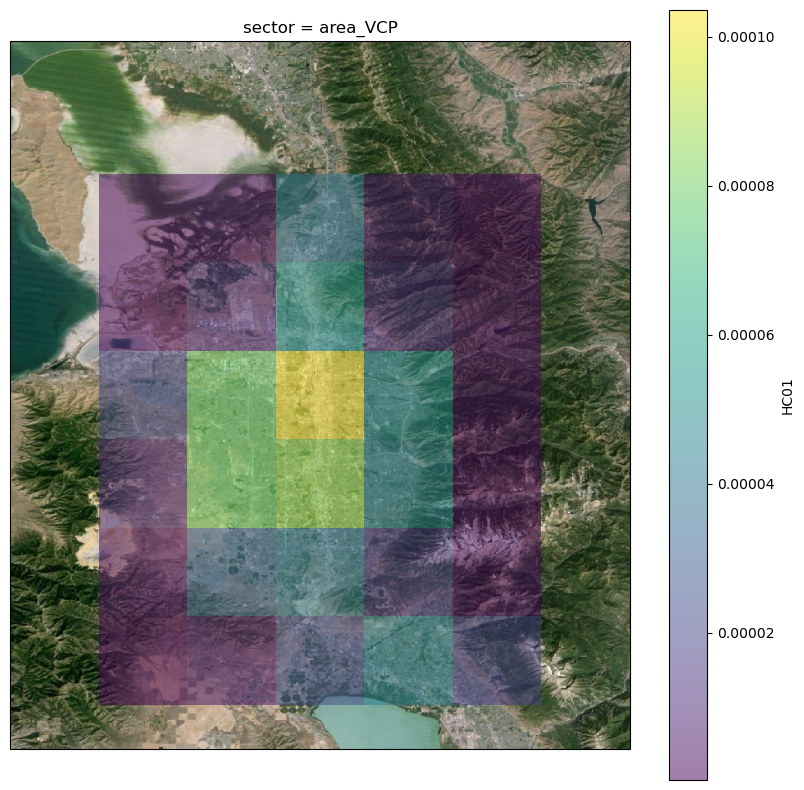

In [21]:
plot_ds = combined_dss['area'].sum(dim=['utc_hour','yr_mo','day_type'])['HC01'].sel({'sector':'area_VCP'})

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)

ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 11.0 # prob have to adjust this
ax.add_image(request,int(scale))

#geo_grid[species].plot.pcolormesh('x','y',ax=ax,alpha = 0.5)
#sc = ax.scatter(plot_ds.lon,plot_ds.lat,c=plot_ds[species],cmap='viridis')
#plt.colorbar(sc)
plot_ds.plot.pcolormesh('lon','lat',ax=ax,alpha = 0.5)
plt.show()

In [111]:
date_range = pd.date_range(dt1,dt2,freq='d')

ds_list = []
for date in date_range:
    yr_mo = f'{date.year}-{date.month}'
    day_type = get_satsunwkd(date)
    ds = ds_combined.sel({'day_type':day_type,'yr_mo':yr_mo}).drop_vars(['day_type','yr_mo'])
    ds = ds.assign_coords(date=date)
    ds = ds.expand_dims(dim=['date'])
    ds_list.append(ds)

newds = xr.combine_by_coords(ds_list)
newds['utc_hour'] = pd.to_timedelta(newds['utc_hour'],'h')
newds.stack(datetime=('date','utc_hour'))



<xarray.Dataset>
Dimensions:   (lat: 6, lon: 4, sector: 1, datetime: 1416)
Coordinates:
  * lat       (lat) float64 40.4 40.5 40.6 40.7 40.8 40.9
  * lon       (lon) float64 -112.0 -111.9 -111.8 -111.7
  * sector    (sector) <U7 'area_OG'
  * datetime  (datetime) object MultiIndex
  * date      (datetime) datetime64[ns] 2019-01-01 2019-01-01 ... 2019-02-28
  * utc_hour  (datetime) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00
Data variables:
    CO2       (sector, lat, lon, datetime) float64 dask.array<chunksize=(1, 6, 4, 24), meta=np.ndarray>

Now we can start to play with subsetting and representing data. 

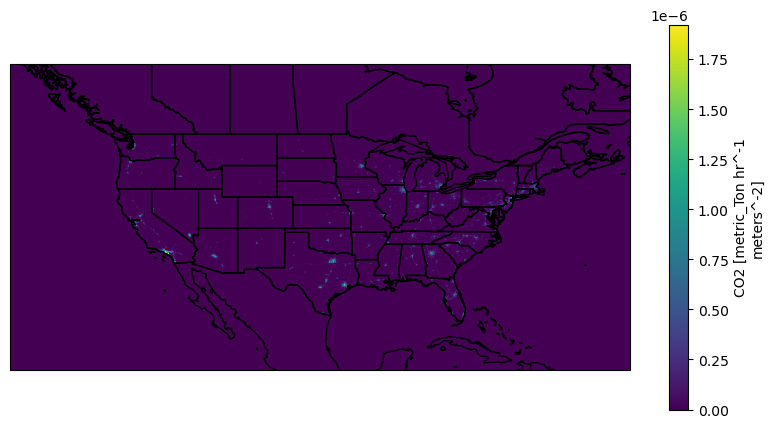

In [25]:
# For example:
# This is the mean daily emission rate of CO2 from onroad_gasoline on a weekday in Jan 2019 for the whole US
spec = 'CO2'
plotds = ds_combined.sel(sector='area_onroad_gasoline',
                         day_type='weekdy',
                         yr_mo='2019-1'
                         )[spec].mean(dim='utc_hour',keep_attrs=True)

#Plotting
proj = ccrs.PlateCarree() #set the projection
fig = plt.figure(figsize=(10,5)) #setup the figure
ax = plt.axes(projection = proj) #setup the axis with correct projection
plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis') #plot the dataset on the ax 
ax.coastlines() #add coastlines
ax.add_feature(cfeature.BORDERS) #borders 
ax.add_feature(cfeature.STATES) #states
plt.title('')
plt.show() #show it

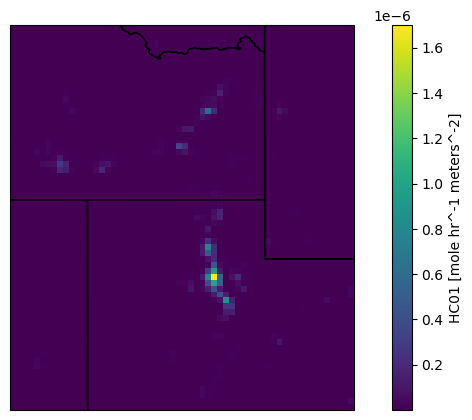

In [27]:
#This is the mean daily emission rate of methane (HC01) from industry on a saturday in Febuary 2019 near northern Utah
# TODO This can take a long time. Find the bottleneck. Suspect it is the lat lon slicing? why tho...

map_extent={'lon_low':-115.4,
            'lon_high':-109.6,
            'lat_low':38.5,
            'lat_high':45.0} #define the extent

plotds = ds_combined.sel(sector='area_Industry',day_type='satdy',yr_mo='2019-2', #sector day type and month
                         lat=slice(map_extent['lat_low'],map_extent['lat_high']), 
                         lon=slice(map_extent['lon_low'],map_extent['lon_high']) #subselect the bounding box in lat lon
                         )['HC01'].mean(dim='utc_hour',keep_attrs = True) #take methane (HC01) and the mean hourly

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection = proj)
plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.title('')
plt.show()

If we wanted to save the dataset to a .nc file for later use:

In [53]:
full_save_path = '/uufs/chpc.utah.edu/common/home/u0890904/test/test_save.nc'
ds_combined.to_netcdf(full_save_path)